# Project for "Wikishop"

The online store "Wikishop" is launching a new service. Now users can edit and supplement product descriptions, similar to wiki communities. In other words, customers suggest their edits and comment on changes made by others. The store needs a tool that will identify toxic comments and send them for moderation.

Train a model to classify comments as positive or negative. You have a dataset with annotations indicating the toxicity of edits.

Build a model with an F1 score of at least 0.75.

# Research plan:

- Load and prepare the data.
- Train different models.
- Choose the most accurate model based on the training results.

Data description:

- text: The text of the comment.
- toxic: The target label indicating toxicity.
- The data is located in the file '/datasets/toxic_comments.csv'.

## Preparation

We import all the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import lightgbm as lgb
import time
import torch
import transformers
import re
import nltk
import random
import spacy
import sys

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from transformers import DistilBertTokenizer
from transformers import DistilBertModel
from scipy.sparse import vstack
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

Let's load the data from the dataset.

In [2]:
pths = ['/Users/daniyardjumaliev/Jupyter/Projects/datasets/toxic_comments.csv', 'backup_path1.csv']

df = None

for pth in pths:
    try:
        df = pd.read_csv(pth)
        print(f'File loaded successfully. {pth}')
    except FileNotFoundError:
        continue

if df is None:
    print('Warning: File not found!')

File loaded successfully. /Users/daniyardjumaliev/Jupyter/Projects/datasets/toxic_comments.csv


Display and check the data quality.

In [3]:
display(df.head(10))
display(df.tail(10))
display(df.describe())
df.info()
display(f'Duplicates: {df.duplicated().sum()}')
display(f'Misiing values:')
display(df.isna().sum())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


,Unnamed: 0,text,toxic
159282,159441,"""\nNo he did not, read it again (I would have ...",0
159283,159442,"""\n Auto guides and the motoring press are not...",0
159284,159443,"""\nplease identify what part of BLP applies be...",0
159285,159444,Catalan independentism is the social movement ...,0
159286,159445,The numbers in parentheses are the additional ...,0
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


'Duplicates: 0'

'Misiing values:'

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Let's remove the column "Unnamed: 0" as it simply duplicates the indices.

In [4]:
df = df.drop('Unnamed: 0', axis=1)
display(df.head(10))
display(df.tail(10))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


,text,toxic
159282,"""\nNo he did not, read it again (I would have ...",0
159283,"""\n Auto guides and the motoring press are not...",0
159284,"""\nplease identify what part of BLP applies be...",0
159285,Catalan independentism is the social movement ...,0
159286,The numbers in parentheses are the additional ...,0
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0
159291,"""\nAnd ... I really don't think you understand...",0


Let's check the balance of the target.

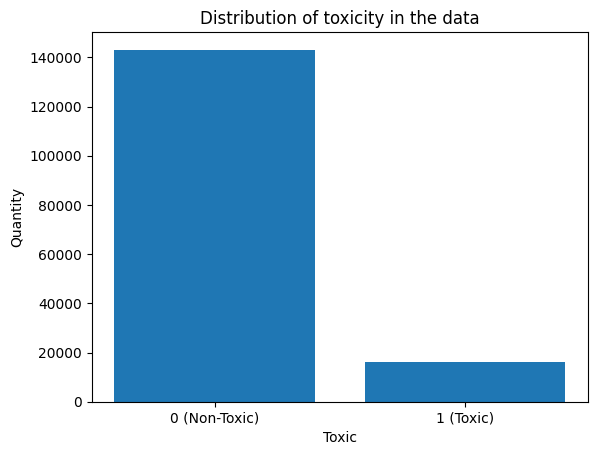

Non-toxic: 143106
Toxic: 16186
Ratio: 8


In [5]:
count_0 = df[df['toxic'] == 0]['toxic'].count()
count_1 = df[df['toxic'] == 1]['toxic'].count()

labels = ['0 (Non-Toxic)', '1 (Toxic)']
values = [count_0, count_1]

plt.bar(labels, values)
plt.xlabel('Toxic')
plt.ylabel('Quantity')
plt.title('Distribution of toxicity in the data')
plt.show()

print(f'Non-toxic: {count_0}')
print(f'Toxic: {count_1}')

print(f'Ratio: {count_0 // count_1}')

_Conclusion_: The dataset does not contain missing values or duplicates. The number of toxic and non-toxic comments is significantly unbalanced, and this should be taken into account when training models.

## Training

We will train toxicity recognition on four models - Logistic Regression, Decision Tree, Random Forest, and LightGBM. Before starting the training of the models, let's prepare the text data to turn them into features. We will do this in three ways: through text tokenization and splitting into n-grams, bag-of-words, also with n-grams, and using the pre-trained BERT method.

In [6]:
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

tqdm.pandas()
df['clean'] = df['text'].progress_apply(clean_text)

display(df.head(10))
display(df.tail(10))

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,clean
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",0,\n\nCongratulations from me as well use the to...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,Sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


,text,toxic,clean
159282,"""\nNo he did not, read it again (I would have ...",0,\nNo he did not read it again I would have tho...
159283,"""\n Auto guides and the motoring press are not...",0,\n Auto guides and the motoring press are not ...
159284,"""\nplease identify what part of BLP applies be...",0,\nplease identify what part of BLP applies bec...
159285,Catalan independentism is the social movement ...,0,Catalan independentism is the social movement ...
159286,The numbers in parentheses are the additional ...,0,The numbers in parentheses are the additional ...
159287,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...
159288,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself \n\nThat is ...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer \n\nUmm theres no actual article for p...
159290,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...
159291,"""\nAnd ... I really don't think you understand...",0,\nAnd I really dont think you understand I c...


In [7]:
nlp = spacy.load("en_core_web_sm")

lemm_texts = []

for doc in tqdm(nlp.pipe(df['clean'].values, disable = ['ner', 'parser']), total=df.shape[0]):
    lemm_text = " ".join([i.lemma_ for i in doc])    
    lemm_texts.append(lemm_text)

df['lemm'] = lemm_texts
    
display(df.head(10))
display(df.tail(10)) 

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,clean,lemm
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...,Explanation \n why the edit make under my user...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...,Daww he match this background colour I m seemi...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...,hey man I m really not try to edit war its jus...
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...,\n More \n I can not make any real suggestion ...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,\n\nCongratulations from me as well use the to...,\n\n congratulation from I as well use the too...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,COCKSUCKER before you pis around on MY work
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...,your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,Sorry if the word nonsense was offensive to yo...,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...,alignment on this subject and which be contrar...


,text,toxic,clean,lemm
159282,"""\nNo he did not, read it again (I would have ...",0,\nNo he did not read it again I would have tho...,\n no he do not read it again I would have thi...
159283,"""\n Auto guides and the motoring press are not...",0,\n Auto guides and the motoring press are not ...,\n auto guide and the motoring press be not g...
159284,"""\nplease identify what part of BLP applies be...",0,\nplease identify what part of BLP applies bec...,\n please identify what part of BLP apply beca...
159285,Catalan independentism is the social movement ...,0,Catalan independentism is the social movement ...,catalan independentism be the social movement ...
159286,The numbers in parentheses are the additional ...,0,The numbers in parentheses are the additional ...,the number in parenthesis be the additional de...
159287,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...,and for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself \n\nThat is ...,you should be ashamed of yourself \n\n that be...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer \n\nUmm theres no actual article for p...,Spitzer \n\n Umm there s no actual article for...
159290,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...,and it look like it be actually you who put on...
159291,"""\nAnd ... I really don't think you understand...",0,\nAnd I really dont think you understand I c...,\n and I really do not think you understand ...


In [8]:
feature = df['clean']
target = df['toxic']

X_train, X_temp, y_train, y_temp = train_test_split(feature, target, test_size=0.3, random_state=12345)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)

print(f'Train features: {X_train.shape}')
print(f'Validation features: {X_val.shape}')
print(f'Test features: {X_test.shape}')
print(f'Train target: {y_train.shape}')
print(f'Validation target: {y_val.shape}')
print(f'Test target: {y_test.shape}')

Train features: (111504,)
Validation features: (23894,)
Test features: (23894,)
Train target: (111504,)
Validation target: (23894,)
Test target: (23894,)


In [9]:
start_time = time.time()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)
X_test = tfidf_vectorizer.transform(X_test)
end_time = time.time()

print(f'Train features: {X_train.shape}')
print(f'Validation features: {X_val.shape}')
print(f'Test features: {X_test.shape}')

Train features: (111504, 176692)
Validation features: (23894, 176692)
Test features: (23894, 176692)


Let's start the training of models and hyperparameter tuning. We'll do this in loops.

Logistic Regression.

In [10]:
#C_values = [0.001, 0.01, 0.1, 1, 10, 100]
C_values = [10]
penalty_values = ['l2']
#tol_values = [1e-4, 1e-3, 1e-2]
#solver_values = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
class_values = ['balanced', None]

best_f1_score = 0
best_params = {}

start_time = time.time()

for C in tqdm(C_values, desc='C loop'):
    for penalty in tqdm(penalty_values, desc='Penalty loop'):
        for class_weight in tqdm(class_values, desc='Class loop'):
                if class_weight == 'balanced':
                    class_weight_param = 'balanced'
                else:
                    class_weight_param = None
                lr = LogisticRegression(solver='saga', class_weight=class_weight_param, max_iter=1000, C=C, penalty=penalty)

                lr.fit(X_train, y_train)

                pred_lr = lr.predict(X_val)

                f1 = f1_score(y_val, pred_lr)

                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {'C': C, 'penalty': penalty, 'class_weight':class_weight}

end_time = time.time()

print(f'Time: {end_time - start_time:.4f} sec')
print("Best hyperparameters:", best_params)
print("f1_score on validation data:", best_f1_score)

C loop:   0%|          | 0/1 [00:00<?, ?it/s]

Penalty loop:   0%|          | 0/1 [00:00<?, ?it/s]

Class loop:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Time: 167.7186 sec
Best hyperparameters: {'C': 10, 'penalty': 'l2', 'class_weight': None}
f1_score on validation data: 0.7912038086601679


Time: 115.3799 sec

Best hyperparameters: {'C': 10, 'penalty': 'l2', 'class_weight': 'balanced'}

f1_score on validation data: 0.7970363718006286

Decision Tree.

In [11]:
#max_depth_values = [5, 10, 20, None]
#min_samples_split_values = [2, 5, 10]
#min_samples_leaf_values = [1, 2, 4]

max_depth_values = [None]
min_samples_split_values = [10]
min_samples_leaf_values = [2]

best_f1_score = 0
best_params = {}

start_time = time.time()

for max_depth in tqdm(max_depth_values, desc='Max Depth loop'):
    for min_samples_split in tqdm(min_samples_split_values, desc='Min Samples Split loop'):
        for min_samples_leaf in tqdm(min_samples_leaf_values, desc='Min Samples Leaf loop'):
            dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

            dt.fit(X_train, y_train)

            pred_dt = dt.predict(X_val)

            f1 = f1_score(y_val, pred_dt)

            if f1 > best_f1_score:
                best_f1_score = f1
                best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

end_time = time.time()

print(f'Time: {end_time - start_time:.4f} sec')
print("Best hyperparameters:", best_params)
print("f1_score on validation data:", best_f1_score)

Max Depth loop:   0%|          | 0/1 [00:00<?, ?it/s]

Min Samples Split loop:   0%|          | 0/1 [00:00<?, ?it/s]

Min Samples Leaf loop:   0%|          | 0/1 [00:00<?, ?it/s]

Time: 314.7776 sec
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 2}
f1_score on validation data: 0.7019522776572668


Time: 2206.2102 sec

Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 2}

f1_score on validation data: 0.7157712305025996


Random Forest.

In [12]:
#n_estimators_values = [100, 200, 300]
#max_depth_values = [10, 20, None]
#min_samples_split_values = [2, 5, 10]
#min_samples_leaf_values = [1, 2, 4]

n_estimators_values = [100]
max_depth_values = [None]
min_samples_split_values = [2]
min_samples_leaf_values = [1]

best_f1_score = 0
best_params = {}

start_time = time.time()

for n_estimators in tqdm(n_estimators_values, desc='n_estimators loop'):
    for max_depth in tqdm(max_depth_values, desc='Max Depth loop'):
        for min_samples_split in tqdm(min_samples_split_values, desc='Min Samples Split loop'):
            for min_samples_leaf in tqdm(min_samples_leaf_values, desc='Min Samples Leaf loop'):
                rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

                rf.fit(X_train, y_train)

                pred_rf = rf.predict(X_val)

                f1 = f1_score(y_val, pred_rf)

                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

end_time = time.time()

print(f'Time: {end_time - start_time:.4f} sec')
print("Best hyperparameters:", best_params)
print("f1_score on validation data:", best_f1_score)

n_estimators loop:   0%|          | 0/1 [00:00<?, ?it/s]

Max Depth loop:   0%|          | 0/1 [00:00<?, ?it/s]

Min Samples Split loop:   0%|          | 0/1 [00:00<?, ?it/s]

Min Samples Leaf loop:   0%|          | 0/1 [00:00<?, ?it/s]

Time: 715.0629 sec
Best hyperparameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
f1_score on validation data: 0.5551067512983267


Time: 9688.4655 sec

Best hyperparameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}

f1_score on validation data: 0.5805902383654937

LightGBM.

In [13]:
#num_leaves_values = [31, 127, 255]
#max_depth_values = [5, 10, 20]
#learning_rate_values = [0.01, 0.1, 0.3]

num_leaves_values = [31]
max_depth_values = [20]
learning_rate_values = [0.3]

best_f1_score = 0
best_params = {}

start_time = time.time()

for num_leaves in tqdm(num_leaves_values, desc='Num Leaves loop'):
    for max_depth in tqdm(max_depth_values, desc='Max Depth loop'):
        for learning_rate in tqdm(learning_rate_values, desc='Learning Rate loop'):
            lgbm = lgb.LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate)

            lgbm.fit(X_train, y_train)

            pred_lgbm = lgbm.predict(X_val)

            f1 = f1_score(y_val, pred_lgbm)

            if f1 > best_f1_score:
                best_f1_score = f1
                best_params = {'num_leaves': num_leaves, 'max_depth': max_depth, 'learning_rate': learning_rate}

end_time = time.time()

print(f'Time: {end_time - start_time:.4f} sec')
print("Best hyperparameters:", best_params)
print("f1_score on validation data:", best_f1_score)

Num Leaves loop:   0%|          | 0/1 [00:00<?, ?it/s]

Max Depth loop:   0%|          | 0/1 [00:00<?, ?it/s]

Learning Rate loop:   0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11298, number of negative: 100206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.616859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597440
[LightGBM] [Info] Number of data points in the train set: 111504, number of used features: 11328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101324 -> initscore=-2.182602
[LightGBM] [Info] Start training from score -2.182602
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Time: 30.2062 sec
Best hyperparameters: {'num

Time: 16259.9911 sec

Best hyperparameters: {'num_leaves': 31, 'max_depth': 20, 'learning_rate': 0.3}

f1_score on validation data: 0.7854561878952123

_Conclusion_: TFIDF (n-gram(1,1)) demonstrated the highest f1_score metric for logistic regression.

__TFIDF(n-gramm(1,1))__

|Model|Hyperparameters|f1_score|
|-----:|-------:|--------:|
|Logistic Regression | (solver='saga', max_iter=1000, C=10, penalty='l2', class_weight='balanced')|0.79|
|Decision Tree | ('max_depth': None, 'min_sample_split': 5, 'min_sample_leaf': 1)|0.7|
|Random Forest | (n_estimators=300, random_state=12345, max_depth=None, min_samples_split=5, min_sample_leaf=1)|0.56|
|LightGBM | (learning_rate=0.3, max_depth=20, num_leaves=31)|0.77|

Now let's try tokenizing the texts using BERT.

__UPD. I tried running both BERT and DistilBERT, but both models consistently overload the kernel, even with 1000 lines and trimming the maximum token length to 512. I couldn't compute anything.__

_Conclusion_: Encoding features using TFIDF (n-gram(1,1)) yielded better results during model training. The logistic regression model achieved the highest f1_score. Now let's evaluate it on the test set with TFIDF encoding.

## Testing

In [14]:
lr = LogisticRegression(solver='saga', max_iter=1000, C=10, penalty='l2', class_weight='balanced')
start_time = time.time()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
end_time = time.time()
score_lr = f1_score(y_test, pred_lr)
print(f'Time: {end_time - start_time:.4f} sec')
print(f'f1_score: {score_lr}')

Time: 153.6381 sec
f1_score: 0.7672980286045612


/Users/daniyardjumaliev/Jupyter/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


_Conclusion_: The model demonstrated an acceptable f1_score metric of 0.77.

## Conclusions

__OVERALL CONCLUSION:__
- During the data loading stage, it was found that the dataset does not contain missing values or duplicates. The number of toxic and non-toxic comments is highly unbalanced, with a ratio of 1 to 8 for toxic and non-toxic comments, respectively.
- ring the training stage, it was decided to use three methods for encoding text data: TFIDF with bigrams, bag-of-words with bigrams, and BERT. In the end, BERT had to be abandoned because even with a sample of 1000 rows from the dataset and trimming the text to 512 tokens, it still consistently overloaded the kernel.
- Next, four models were trained: Logistic Regression, Decision Tree, Random Forest, and LightGBM, using TFIDF tokenization, and the following results were obtained:

__TFIDF(n-gramm(1,1))__

|Model|Hyperparameters|f1_score|
|-----:|-------:|--------:|
|Logistic Regression | (solver='saga', max_iter=1000, C=10, penalty='l2', class_weight='balanced')|0.79|
|Decision Tree | ('max_depth': None, 'min_sample_split': 5, 'min_sample_leaf': 1)|0.7|
|Random Forest | (n_estimators=300, random_state=12345, max_depth=None, min_samples_split=5, min_sample_leaf=1)|0.56|
|LightGBM | (learning_rate=0.3, max_depth=20, num_leaves=31)|0.77|


- As seen, the Logistic Regression and LightGBM models showed good results with TFIDF text encoding. However, in the end, it was decided to test the Logistic Regression model on the test set. __It showed an f1_score of 0.77. Such a model can be recommended for implementation to determine the toxicity of comments on the platform__._